In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import clean as clean

In [3]:
# Load and clean the data
df_path = "../data/TBI PUD 10-08-2013.csv"
df = clean.clean_data(df_path)

# Fill missing values with the mean of each column
df = df.apply(lambda col: col.fillna(col.mean()), axis=0)

In [4]:
# Split into training and test sets
temp_df, test_df = train_test_split(df, test_size=0.2, random_state=42) # 20% test
train_df, val_df = train_test_split(temp_df, test_size=0.25, random_state=42) # 60% train, 20% val

# Separate features (X) and target (y)
y_train = train_df["PosIntFinal"]
X_train = train_df.drop(columns=["PosIntFinal"])
y_val = val_df["PosIntFinal"]
X_val = val_df.drop(columns=["PosIntFinal"])
y_test = test_df["PosIntFinal"]
X_test = test_df.drop(columns=["PosIntFinal"])

In [5]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [6]:
# Train the neural network model

# Define the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

def weighted_binary_crossentropy(y_true, y_pred):
    # Define weights for false negatives and false positives
    weight_for_fn = 3.0  # Increase the value to penalize false negatives more
    weight_for_fp = 1.0
    # Compute binary cross-entropy
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    # Apply weights
    weight_vector = y_true * weight_for_fn + (1 - y_true) * weight_for_fp
    return bce * weight_vector

# Define the custom metric for false negative rate
def false_negative_rate(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert probabilities to binary predictions
    fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 0)), tf.float32))
    positives = tf.reduce_sum(tf.cast(tf.equal(y_true, 1), tf.float32))
    return fn / (positives + tf.keras.backend.epsilon())  # Avoid division by zero

# Compile the model with custom metrics
model.compile(
    optimizer='adam', 
    loss=weighted_binary_crossentropy, 
    metrics=[
        'accuracy', 
        tf.keras.metrics.Recall(name='recall'), 
        false_negative_rate
    ]
)

# Train the model
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=50, batch_size=32, 
    verbose=1
)

# Evaluate the model
# Predict probabilities on the test set
y_pred_prob = model.predict(X_val)

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype("int32")

Epoch 1/50


/opt/miniconda3/envs/215a/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


789/789 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9861 - false_negative_rate: 0.3145 - loss: 0.0856 - recall: 0.2567 - val_accuracy: 0.9863 - val_false_negative_rate: 0.3010 - val_loss: 0.0471 - val_recall: 0.2690
Epoch 2/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step - accuracy: 0.9883 - false_negative_rate: 0.2514 - loss: 0.0379 - recall: 0.3636 - val_accuracy: 0.9862 - val_false_negative_rate: 0.3112 - val_loss: 0.0455 - val_recall: 0.2621
Epoch 3/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - accuracy: 0.9887 - false_negative_rate: 0.2486 - loss: 0.0345 - recall: 0.4033 - val_accuracy: 0.9863 - val_false_negative_rate: 0.2655 - val_loss: 0.0411 - val_recall: 0.3655
Epoch 4/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - accuracy: 0.9898 - false_negative_rate: 0.2217 - loss: 0.0289 - recall: 0.4434 - val_accuracy: 0.9875 - val_false_negative_rate: 0.2256 - val_loss: 0.0382 - val_recall: 0.4621
Epoch 5/50
789/789 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - accuracy: 0.9895 - false_nega

In [7]:
# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report with precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_val, y_pred, digits=4))

Confusion Matrix:
[[8218   44]
 [  84   61]]
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9899    0.9947    0.9923      8262
         1.0     0.5810    0.4207    0.4880       145

    accuracy                         0.9848      8407
   macro avg     0.7854    0.7077    0.7401      8407
weighted avg     0.9828    0.9848    0.9836      8407



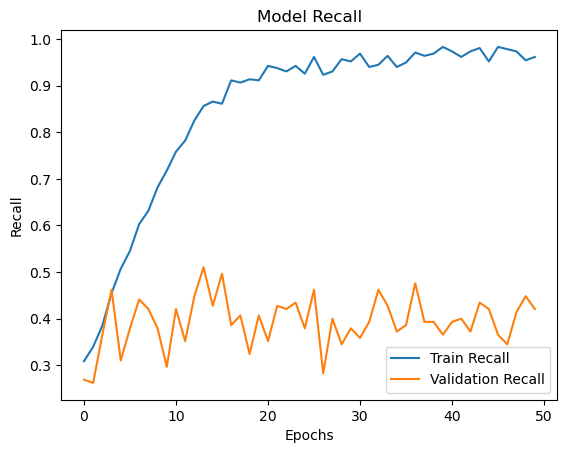

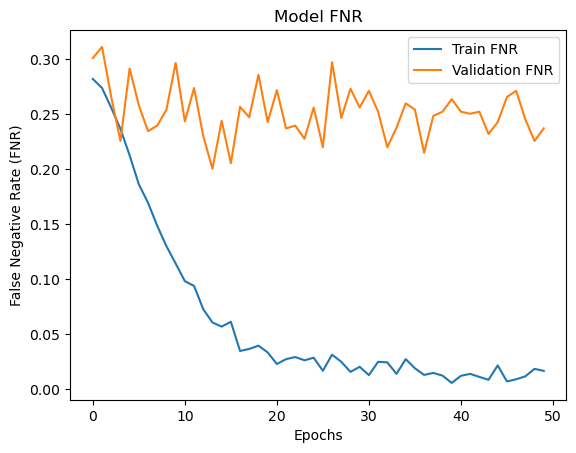

In [8]:
# Visualize training history
# Recall plot
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Model Recall')
plt.show()

# False Negative Rate plot
plt.plot(history.history['false_negative_rate'], label='Train FNR')
plt.plot(history.history['val_false_negative_rate'], label='Validation FNR')
plt.xlabel('Epochs')
plt.ylabel('False Negative Rate (FNR)')
plt.legend()
plt.title('Model FNR')
plt.show()

In [9]:
# Predict on the test set
y_test_prob = model.predict(X_test)
y_test_pred = (y_test_prob > 0.5).astype("int32")

263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


In [11]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report with precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

Confusion Matrix:
[[8179   75]
 [  91   63]]
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9890    0.9909    0.9900      8254
         1.0     0.4565    0.4091    0.4315       154

    accuracy                         0.9803      8408
   macro avg     0.7228    0.7000    0.7107      8408
weighted avg     0.9792    0.9803    0.9797      8408



In [ ]:
# Save the probability predictions
# np.save("nn.npy", y_pred_prob)